In [6]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN = False
np.random.seed(0)

In [7]:
def median_smoother(arr, indices, window_size, buffer_size):
    smoothed = np.copy(arr)
    for idx in indices:
        # Smooth buffer regions around each index in indices
        for i in range(1, buffer_size + 1):
            if idx - i >= 0:
                start = max(0, idx - i - window_size // 2)
                end = min(len(arr), idx - i + window_size // 2 + 1)
                smoothed[idx - i] = np.median(arr[start:end])
            if idx + i < len(arr):
                start = max(0, idx + i - window_size // 2)
                end = min(len(arr), idx + i + window_size // 2 + 1)
                smoothed[idx + i] = np.median(arr[start:end])
        start = max(0, idx - window_size // 2)
        end = min(len(arr), idx + window_size // 2 + 1)
        smoothed[idx] = np.median(arr[start:end])
    return smoothed

    

In [8]:
def visualize_cdf_pdf(params, sample=[], distro = 'gengamma', log_scale = True, n_samples=2000, interval = None, provided_loc = None, group=None, percent_excluded=0.1, plot_hist=True, bw = 0.05, bw_log = 0.05, binwidth = None):
    """
    Visualize the gap between the empirical CDF/PDF and the Computed CDF/PDF.

    Args:
        sample (np.ndarray): Observed data.
        r (float): r value.
        eta (float): eta value.
        n_samples (int): Number of samples for the computed CDF/PDF.
        all_cdfs (dict): Dictionary containing computed CDFs.
        group (int or None): Group index (for titling purposes).

    Returns:
        distance (float): The Kolmogorov-Smirnov statistic.
        location (float): The location of the maximum deviation between the empirical and computed CDFs.
    """
    if len(sample) > 0:
        
        lower_bound = np.percentile(sample, percent_excluded/2)
        upper_bound = np.percentile(sample, (100-percent_excluded/2))
        original_sample = sample
        sample = sample[(sample > lower_bound) & (sample < upper_bound)]
        sample = np.sort(sample)
        n = len(sample)
        # If interval not specified, set to include 99% of the data
        if interval is None:
            interval = (np.percentile(sample, 5), np.percentile(sample, 95))
        xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 2000000)
    
    ################# NEW CODE #################
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale = scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        
        if scale > 10:
            xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale = scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
            if scale != 1:
                xs_1, pdf_1 = compute_prior_pdf(r=r, eta=eta, scale = 1, n_samples=n_samples, enforce_assert=False, debug=False)
                y = pdf_1(xs_1)
                indices = np.concatenate([
                    np.where(y < 0)[0],
                    np.where(y > np.percentile(y, 99))[0],
                        ])
                indices = np.unique(indices)

                new_y = median_smoother(y, indices=indices, window_size=25, buffer_size=10)
                pdf = interpolate.CubicSpline(x=xs_1, y=new_y)
                null_pdf = pdf(xs_pdf/np.sqrt(scale)) / np.sqrt(scale)
        else:
            ########### END NEW CODE ###########
            null_pdf = null_cdf.derivative()(xs_pdf)
        
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)

    if log_scale:

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
        fig.suptitle(f'{f"{GROUP_NAME} {group}" if group else ""} Empirical CDF vs Computed CDF \n (r={r}, eta={eta}, scale={np.format_float_scientific(scale, 3)})', fontsize=14)
        if interval:
            ax1.set_xlim(left = interval[0], right = interval[1])

        if len(sample) > 0:
            ax1.plot(sample, np.arange(1, n+1)/n, label='Empirical CDF')
            result = stats.ks_1samp(original_sample, null_cdf)
            distance = result.statistic
            location = result.statistic_location
            emp_cdf_at_loc = np.searchsorted(original_sample, location, side='right') / n
            computed_cdf_at_loc = null_cdf(location)
            ax1.plot(xs, null_cdf(xs), label='Computed CDF')
            ax1.vlines(location, emp_cdf_at_loc, computed_cdf_at_loc, linestyles='--', label=f'Maximum Deviation: {np.round(distance, 6)}\nat x={np.format_float_scientific(location, 3)}', color='xkcd:bright red')
        else:
            ax1.plot(xs_pdf, null_cdf(xs_pdf), label='Computed CDF')

        if len(sample) > 0 and provided_loc:
            emp_cdf_at_provided_loc = np.searchsorted(original_sample, provided_loc, side='right') / n
            computed_cdf_at_provided_loc = null_cdf(provided_loc)
            ax1.vlines(provided_loc, emp_cdf_at_provided_loc, computed_cdf_at_provided_loc, linestyles='--', label=f'Deviation: {np.round(emp_cdf_at_provided_loc - computed_cdf_at_provided_loc, 6)}\nat x={np.round(provided_loc, 6)}', color='xkcd:shamrock green')

        if interval:
            ax2.set_xlim(left = interval[0], right = interval[1])
        
        if len(sample)>0:
            sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method = bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})')
            if plot_hist:
                sns.histplot(sample, ax=ax2, binwidth = binwidth, stat='density', label=f'Empirical PDF ({100-percent_excluded}% of sample)', alpha=0.2)
        ax2.plot(xs_pdf, null_pdf, label='Computed PDF')
       
        if interval:
            ax3.set_xlim(left = interval[0], right = interval[1])
        ax3.set_ylim(bottom = 10**-4, top=10)
        
        if len(sample)>0:
            sns.kdeplot(ax = ax3, x = sample, bw_method = bw_log, log_scale=[False, True], label = f"Empirical PDF (KDE, bw={bw_log})")
            if plot_hist:
                sns.histplot(sample, ax = ax3, binwidth = binwidth, stat = "density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100-percent_excluded}% of sample)')

        ax3.plot(xs_pdf, null_pdf, label = "Computed PDF")
        
        if len(sample) == 0:
            ax1.set_title(f'Visualized {distro} CDF with params {params}')
            ax2.set_title(f'Visualized {distro} PDF with params {params}')
            ax3.set_title(f'Visualized {distro} PDF (log-scale) with params {params}')
        elif distro == 'gengamma':
            ax1.set_title(f'Empirical CDF vs Computed CDF (p-value:{np.format_float_scientific(result.pvalue, 4)})')
            ax2.set_title(f'Empirical PDF vs Computed PDF')
            ax3.set_title(f'Log Scale: Empirical PDF vs Computed PDF')
        ax1.legend()
        ax2.legend()
        ax3.legend()

        plt.tight_layout()
        plt.show()
        
    return fig

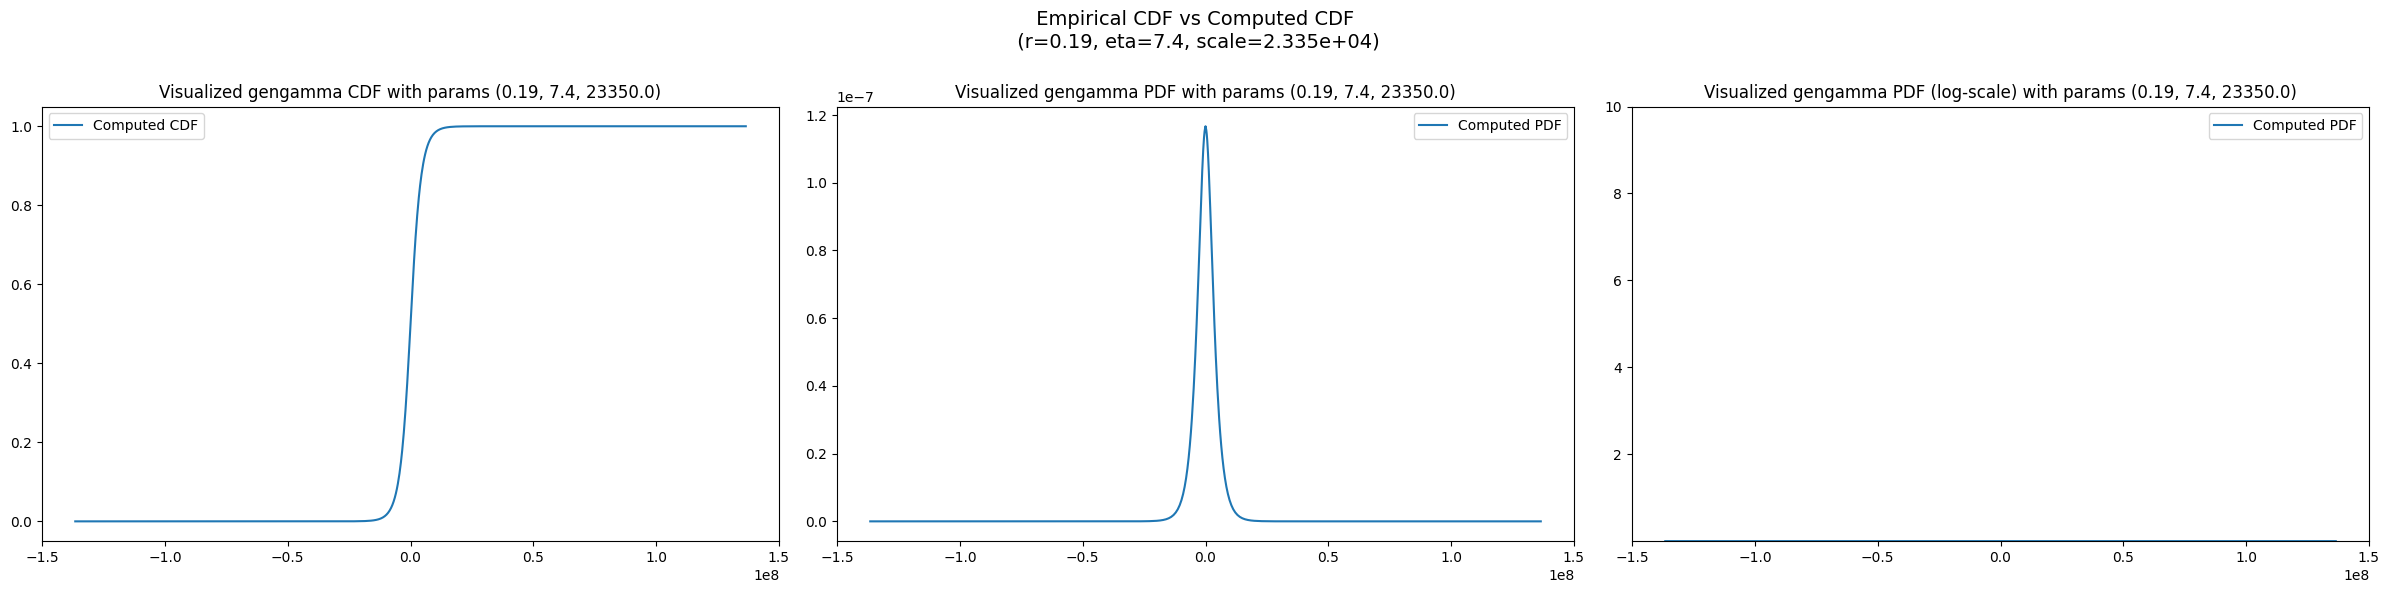

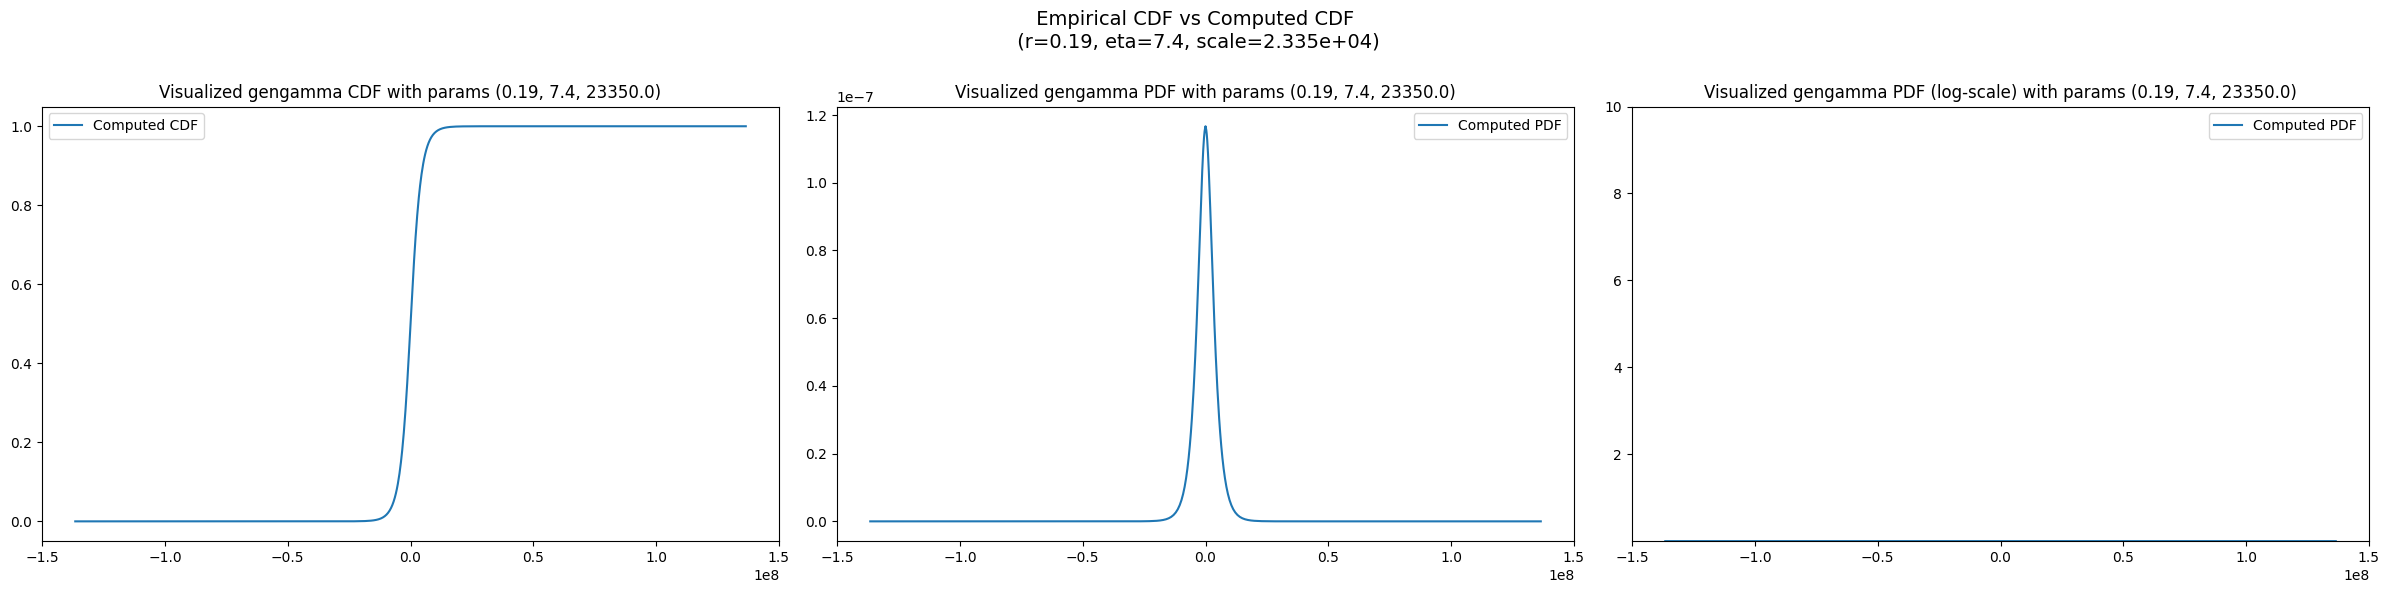

In [10]:
n_samples = 2000

r=0.19 
eta=7.4 
scale = 2.335e4

visualize_cdf_pdf(params=(r, eta, scale), distro='gengamma', log_scale=True, n_samples=n_samples, interval=None, provided_loc=None, percent_excluded=0.1, plot_hist=True, bw = 0.05, bw_log = 0.05, binwidth = None)